# バンディットアルゴリズム　シミュレーター

## Bandit Algorithm とは
> 環境に対する不完全な事前知識を活用して行動し、<br/>
環境を観測してデータを集めながら最適な行動を発見する（探索と活用）アルゴリズムがバンディットアルゴリズムです。 <br/>
(https://techblog.zozo.com/entry/zozoresearch-bandit-overviews より引用) 
## 環境構築（インストールについて）
このライブラリでは、Docker compose を利用したPython 環境を構築した。

Docker 環境を使用するのが難しい場合、Docker を使用せず、Anacondaを
インストールしてPython 環境を構築しても良い

（後で記入する）

## 課題の定義について

- 腕
    - アタリの場合の報酬が1, ハズレの場合の報酬が0である5つの腕
    - それぞれの腕はそれぞれ、アタリの確率が10%, 30%, 50%, 70%, 90%のベルヌーイ分布に従う。
- （一回のシミュレーションにおける）試行回数
    - 1000回
- シミュレーション回数
    - 1000回
- 評価指標
    1. 各試行回数における報酬の平均（早く最適な腕を見つける性能を評価）
    2. 各試行回数までの累積報酬（500回の試行において全体的な報酬を最大化する性能を評価）
- 比較アルゴリズム
    - ε-greedy (ϵ=0.2ϵ=0.2)
    - ε-greedy (ϵ=0.5ϵ=0.5)
    - Softmax (τ=0.2τ=0.2)
    - Softmax (τ=0.5τ=0.5)
    - UCB1


In [1]:
from numpy.random import randint,binomial


In [36]:

# p: success probability
class Arm:
    def __init__(self, p):
        self._p = p 
        self.success = 0
        self.fail = 0
        
    def play(self):
        result = binomial(n = 1, p = self._p)
        if result ==1:
            self.success+=1
        else: 
            self.fail +=1
        return result 


In [40]:

def __calc_success_ratio(arm):
    if arm.success + arm.fail == 0:
        return 0
    return arm.success / (arm.success + arm.fail)

def epsilon_greedy(arms, T, epsilon):
    reward = 0
    for i in range(1, T+1):
        if binomial(n=1, p=epsilon) == 1:
            # 探索ステップ : アームを一様ランダムに選ぶ
            index = randint(0, len(arms))
        else:
            # 活用ステップ : 今までで一番成功確率の高いアームを選ぶ
            avgs = [ __calc_success_ratio(arm) for arm in arms]
            index = avgs.index(max(avgs))
        reward += arms[index].play()
    return reward


In [22]:
import math 

def __init(arms):
    for arm in arms:
        arm.success = 1
    return arms

def __get_score(arm, t):
    ucb = math.sqrt(2*math.log(t) / (arm.success + arm.fail))
    return arm.success / (arm.success + arm.fail) + ucb

def UCB(arms, T):
    __init(arms)
    reward = 0

    for i in range(1, T+1):
        scores = [__get_score(arm, i) for arm in arms]
        max_score_index = scores.index(max(scores))
        reward += arms[max_score_index].play()
    return reward


In [34]:
from numpy.random import beta 

def thompson_sampling(arms, T):
    reward = 0
    for i in range(1,T+1):
        rand_gened_params = [beta(a=arm.success+1, b=arm.fail+1) for arm in arms]
        max_index = rand_gened_params.index(max(rand_gened_params))
        reward += arms[max_index].play()
    return reward

In [50]:

import numpy as np

def simulate_eg(epsilon):
    arms = [Arm(0.3) for i in range(4)]
    arms.append(Arm(0.5))
    return epsilon_greedy(arms=arms, T=10**3, epsilon=epsilon)

def simulate_ucb():
    arms = [Arm(0.3) for i in range(4)]
    arms.append(Arm(0.5))
    return UCB(arms=arms, T=10**3)

def simulate_ts():
    arms = [Arm(0.3) for i in range(4)]
    arms.append(Arm(0.5))
    return thompson_sampling(arms=arms, T=10**3)

def __out_benchmark(array):

    print('\t Avg: {}, Std: {}, Max: {}, Min: {}'.format(np.average(array), np.std(array), np.max(array), np.min(array)))


if __name__ == "__main__":
    loop_cnt = 100
    eg_3_reward_hist = []
    eg_5_reward_hist = []
    eg_7_reward_hist = []
    ucb_reward_hist = []
    ts_reward_hist = []
    for i in range(loop_cnt):
        eg_3_reward_hist.append(simulate_eg(0.3))
        eg_5_reward_hist.append(simulate_eg(0.5))
        eg_7_reward_hist.append(simulate_eg(0.7))
        ucb_reward_hist.append(simulate_ucb())
        ts_reward_hist.append(simulate_ts())

    print('Epsilon-greedy_0.3')
    __out_benchmark(eg_3_reward_hist)
    print('Epsilon-greedy_0.5')
    __out_benchmark(eg_5_reward_hist)
    print('Epsilon-greedy_0.7')
    __out_benchmark(eg_7_reward_hist)
    print('UCB')
    __out_benchmark(ucb_reward_hist)
    print('Thompson sampling')
    __out_benchmark(ts_reward_hist)

Epsilon-greedy_0.3
	 Avg: 437.27, Std: 27.45900762955573, Max: 482, Min: 329
Epsilon-greedy_0.5
	 Avg: 413.01, Std: 19.12145130475195, Max: 449, Min: 333
Epsilon-greedy_0.7
	 Avg: 383.71, Std: 16.73038851909901, Max: 428, Min: 343
UCB
	 Avg: 408.47, Std: 18.039099201456818, Max: 444, Min: 359
Thompson sampling
	 Avg: 470.72, Std: 22.858731373372407, Max: 537, Min: 394


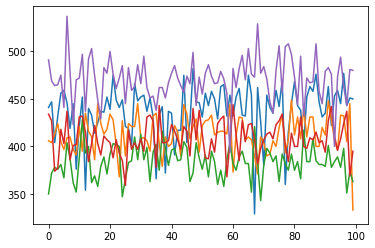

In [51]:
import matplotlib.pyplot as plt 
%matplotlib inline

plt.plot(eg_3_reward_hist)
plt.plot(eg_5_reward_hist)
plt.plot(eg_7_reward_hist)
plt.plot(ucb_reward_hist)
plt.plot(ts_reward_hist)

## 参考文献
- [多腕バンディット入門：3つのアルゴリズムをpythonで実装する](https://zenn.dev/5nta/articles/78361b28d414b54df29b#%E3%81%BE%E3%81%A8%E3%82%81)